<a href="https://colab.research.google.com/github/kyriakos77kolovos/ergasies_python/blob/master/colab_sound_model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
import numpy as np
from time import time

from warnings import filterwarnings

from os import listdir
from os.path import splitext, basename, join

from librosa import load, stft, magphase, amplitude_to_db
from librosa.feature import melspectrogram

from keras.utils import np_utils
from keras.layers import BatchNormalization
from tensorflow.python.ops.math_ops import reduce_mean
from tensorflow.python.keras.layers import Input, LSTM, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Global variables
SAMPLE_RATE = 16000
PATH_TO_SAVE_MODELS = "/content/drive/MyDrive/ASR/ASR_Project-main/TrainedDataSet/"
WINDOWS_LENGTH = 0.5
# HOP_LENGTH = round(WINDOWS_LENGTH * SAMPLE_RATE)
HOP_LENGTH = 512

In [ ]:
def showMelSpectrogram(digit):
    """
    :param digits: list of digits/digit
    :return: list of mel spectrogram/mel spectrogram
    """

    spectrogram = stft(digit)
    spectrogram_mag, _ = magphase(spectrogram)

    mel_spectrogram = melspectrogram(S=spectrogram_mag, sr=SAMPLE_RATE)
    mel_spectrogram = amplitude_to_db(mel_spectrogram, ref=np.min)

    return mel_spectrogram

In [ ]:
trained_data_path = "/content/drive/MyDrive/ASR/ASR_Project-main/TrainedDataSet/audio/"
data_dir = pathlib.Path(trained_data_path)
numbers_labels = np.array(listdir(str(data_dir)))
numbers_labels = numbers_labels[numbers_labels != '_background_noise_']
numbers_labels = numbers_labels[numbers_labels != '.DS_Store']
print(numbers_labels)

['six' 'eight' 'seven' 'one' 'four' 'three' 'zero' 'five' 'nine' 'two']


In [ ]:
all_labels, trained_samples = [], []
zero, one, two, three, four, five, six, seven, eight, nine = [], [], [], [], [], [], [], [], [], []
for number_label in numbers_labels:
    label_path = join(data_dir, number_label)
    for file in listdir(label_path):

        signal_sample, samples_rate = load(pathlib.Path(str(join(label_path, file))), sr=SAMPLE_RATE)
        
        if len(signal_sample) == SAMPLE_RATE:
            spectrogram = stft(signal_sample)
            spectrogram_mag, _ = magphase(spectrogram)

            mel_spectrogram = melspectrogram(S=spectrogram_mag, sr=SAMPLE_RATE)
            mel_spectrogram = amplitude_to_db(mel_spectrogram, ref=np.min)

            if number_label == "zero":
                zero.append(mel_spectrogram)
            elif number_label == "one":
                one.append(mel_spectrogram)
            elif number_label == "two":
                two.append(mel_spectrogram)
            elif number_label == "three":
                three.append(mel_spectrogram)
            elif number_label == "four":
                four.append(mel_spectrogram)
            elif number_label == "five":
                five.append(mel_spectrogram)
            elif number_label == "six":
                six.append(mel_spectrogram)
            elif number_label == "seven":
                seven.append(mel_spectrogram)
            elif number_label == "eight":
                eight.append(mel_spectrogram)
            elif number_label == "nine":
                nine.append(mel_spectrogram)
                      
            trained_samples.append(mel_spectrogram)
            all_labels.append(number_label)

In [ ]:
meaned_zero = np.mean(zero, axis=2)
meaned_one = np.mean(one, axis=2)
meaned_two = np.mean(two, axis=2)
meaned_three = np.mean(three, axis=2)
meaned_four = np.mean(four, axis=2)
meaned_five = np.mean(five, axis=2)
meaned_six = np.mean(six, axis=2)
meaned_seven = np.mean(seven, axis=2)
meaned_eight = np.mean(eight, axis=2)
meaned_nine = np.mean(nine, axis=2)

In [ ]:
trained_mean_data = []

In [ ]:
trained_mean_data.extend(meaned_zero)
trained_mean_data.extend(meaned_one)
trained_mean_data.extend(meaned_two)
trained_mean_data.extend(meaned_three)
trained_mean_data.extend(meaned_four)
trained_mean_data.extend(meaned_five)
trained_mean_data.extend(meaned_six)
trained_mean_data.extend(meaned_seven)
trained_mean_data.extend(meaned_eight)
trained_mean_data.extend(meaned_nine)

In [ ]:
all_labels = np.array(all_labels)
trained_mean_data = np.array(trained_mean_data).reshape(-1, 128, 1)

print(all_labels.shape)
print(trained_mean_data.shape)

(21588,)
(21588, 128, 1)


In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(all_labels)
classes_count = len(list(label_encoder.classes_))
y = np_utils.to_categorical(y, num_classes=classes_count, dtype='float32')

In [ ]:
# saving labelEncoder
import pickle 
path = "/content/drive/MyDrive/ASR/ASR_Project-main/TrainedDataSet/labelEncoderModel1.sav"
pickle.dump(label_encoder, open(path, 'wb'))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(trained_mean_data,
                                                    np.array(y),
                                                    stratify=y,
                                                    test_size=0.2,
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2)

x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [ ]:
print(np.array(x_train).shape)
print(np.array(y_train).shape)
print(np.array(x_test).shape)
print(np.array(y_test).shape)
print(np.array(x_val).shape)
print(np.array(y_val).shape)

(13816, 128, 1)
(13816, 10)
(4318, 128, 1)
(4318, 10)
(3454, 128, 1)
(3454, 10)


In [ ]:
input_shape = x_train.shape[1]

model = Sequential()

# Adding Layers
# 1st LSTM layer
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
# 2nd LSTM layer
model.add(LSTM(64))

# 1st Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Outputs
model.add(Dense(classes_count, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 64)           16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 54,730
Trainable params: 54,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   patience=6, 
                   min_delta=0.0001)

mc = ModelCheckpoint('best_model.hdf5', 
                     monitor='val_acc',
                     save_best_only=True, 
                     mode='max')

In [1]:
model_history = model.fit(x_train, y_train, 
                          validation_data=(x_val, y_val), 
                          epochs=100, callbacks=[es, mc],
                          batch_size = 32)

NameError: ignored

In [ ]:
# SAving model 
filename = pathlib.Path(join(PATH_TO_SAVE_MODELS, 'mean_model.h5'))
model.save(filename)

In [ ]:
history_dict = model_history.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']

In [ ]:
# Save history
import pickle 
from pandas import DataFrame

history_df = DataFrame(history_dict)
filename = pathlib.Path(join(PATH_TO_SAVE_MODELS, 'history_mean_model1.csv'))
with open(filename, 'w') as f:
    history_df.to_csv(f)

In [ ]:
import matplotlib.pyplot as plt

epochs=range(1,len(loss_values) + 1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
train_score = model.evaluate(x_train, y_train, batch_size=32)
test_score = model.evaluate(x_test, y_test, batch_size=32)

print(train_score)
print(test_score)

In [ ]:
from tensorflow.math import confusion_matrix
y_predict = model.predict(x_test)
conf_mat = confusion_matrix(np.argmax(y_test,axis=1) , 
                           np.argmax(y_predict,axis=1))

In [ ]:
import pandas as pd
import seaborn as sn

In [ ]:
classes = label_encoder.classes_
df_cm = pd.DataFrame(np.array(conf_mat), index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (13,7))
ax = sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("True Class"     , fontsize=20)
plt.xlabel("Predicted Class", fontsize=20)
plt.show()

In [ ]:
from pandas import read_csv
with open(filename, 'r') as f:
    tmp = read_csv(f)

In [ ]:
import matplotlib.pyplot as plt

def plotHistory(history_dict):
    loss_values = history_dict['loss']
    acc_values = history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values=history_dict['val_accuracy']

    epochs=range(1,len(loss_values) + 1)
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    ax1.plot(epochs,loss_values,'co',label='Training Loss')
    ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs,acc_values,'co', label='Training accuracy')
    ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()
    plt.close()

In [ ]:
plotHistory(tmp)

In [ ]:
def predict(audio):
    prob=model.predict(audio)
    index=np.argmax(prob[0])
    return classes[index]

In [ ]:
path_to_file = pathlib.Path("/content/drive/MyDrive/ASR/ASR_Project-main/TrainedDataSet/samples/ergasia2.wav")
signal, _ = load(path_to_file, sr=SAMPLE_RATE)  # Loading audio file

In [ ]:
from librosa.effects import preemphasis, trim
from librosa.feature import zero_crossing_rate
from noisereduce import reduce_noise
from scipy.signal import get_window, convolve

from librosa.display import specshow, waveshow
from librosa import frames_to_time, frames_to_samples, time_to_samples, amplitude_to_db
from librosa.effects import trim, split
from librosa.feature import mfcc
from librosa.onset import onset_detect
from librosa.sequence import dtw

In [ ]:
def signalFiltering(signal_sample):
    # Pre emphasized
    pre_emphasized_signal = preemphasis(signal_sample)

    # Reducing noise
    reduced_noise_signal = reduce_noise(pre_emphasized_signal, sr=SAMPLE_RATE)

    # Removing parts where the audio is less than 40db.
    filtered_signal, _ = trim(reduced_noise_signal, 40)

    return filtered_signal

In [ ]:
filtered_signal = signalFiltering(signal)

In [ ]:
WINDOWS_LENGTH = 0.09

In [ ]:
def digitSegmentation(filtered_signal):
    # Reversing filtered_signal
    reversed_filtered_signal = filtered_signal[::-1]

    detected_frames = onset_detect(filtered_signal, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
    frames_time = frames_to_time(detected_frames, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
    frames_samples = frames_to_samples(detected_frames, hop_length=HOP_LENGTH)

    reversed_detected_frames = onset_detect(reversed_filtered_signal, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
    reversed_frames_time = frames_to_time(reversed_detected_frames, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)

    for i in range(len(reversed_frames_time)):
        reversed_frames_time[i] = WINDOWS_LENGTH - reversed_frames_time[i]

    # Sorting array
    reversed_frames_time = sorted(reversed_frames_time)

    # Removing silent parts to split sounds.
    i = 0
    while i < len(reversed_frames_time) - 1:
        if reversed_frames_time[i + 1] - reversed_frames_time[i] < 1:
            reversed_frames_time = np.delete(reversed_frames_time, i)
            i -= 1
        i += 1

    i = 0
    while i < len(frames_time) - 1:
        if frames_time[i + 1] - frames_time[i] < 1:
            frames_time = np.delete(frames_time, i + 1)
            detected_frames = np.delete(detected_frames, i + 1)
            frames_samples = np.delete(frames_samples, i + 1)
            i = i - 1
        i = i + 1

    # Merging times
    merged_arrays = np.concatenate([frames_time, reversed_frames_time])
    merged_frames_times = sorted(merged_arrays)

    s = time_to_samples(merged_frames_times, sr=SAMPLE_RATE)
    return s

In [ ]:
def displayTime(startFrame, endFrame):    
    print(' start time: ' + str(startFrame/SAMPLE_RATE) + ', end time: ' + str(endFrame/SAMPLE_RATE))

In [ ]:
def testSplit(filtered_signal):
    n_fft = 2048
    S = stft(filtered_signal, n_fft=n_fft, hop_length=n_fft//2)
    print(S.shape)

    # convert to db
    D = amplitude_to_db(np.abs(S), ref=np.max)
    max_Db = np.max(abs(D))
    print(max_Db)

    nonMuteSections = split(filtered_signal)

    for i in nonMuteSections:
      displayTime(i[0], i[1])

In [ ]:
def concatenceSegments(segments, pad_time=0.300):
    return [np.concatenate([segment, np.zeros(int(pad_time * SAMPLE_RATE))] for segment in segments)]

In [ ]:
def testSplit2(filtered_signal):
    # test

    onset_frames = onset_detect(filtered_signal, sr=SAMPLE_RATE)
    onset_times = frames_to_time(onset_frames, sr=SAMPLE_RATE)
    onset_samples = frames_to_samples(onset_frames)

    frames_sz = int(0.100 * SAMPLE_RATE)
    segments = np.array([filtered_signal[i:i + frames_sz] for i in onset_samples])

    concatence_signals = concatenceSegments(segments)
    print(concatence_signals)

In [ ]:
def showSignal(signal):
    plt.figure(figsize=(14, 5))
    waveshow(signal, sr=SAMPLE_RATE)
    plt.grid()
    plt.show()
    plt.close()

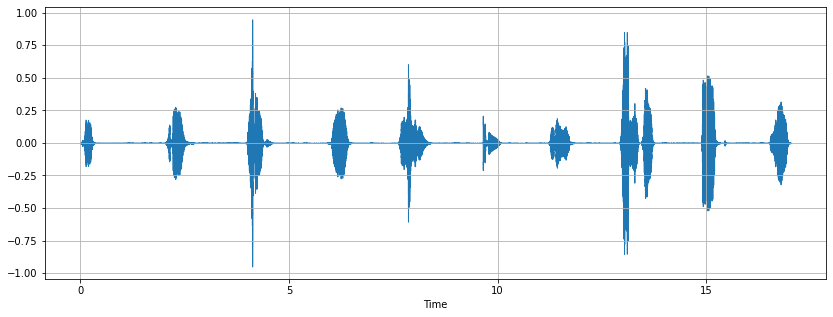

In [ ]:
showSignal(filtered_signal)

In [ ]:
def digitsFounder(signal_data, samples):
    samples_length = len(samples)
    digits_found_counter = 0
    digits_found = []

    plt.figure(figsize=(14, 5))

    # From 0 to samples_length, skipping 2
    for i in range(0, samples_length, 2):
        if samples_length % 2 == 1 and i == samples_length - 1:
            digit = signal_data[samples[i - 1]:samples[i]]
        else:
            digit = signal_data[samples[i]:samples[i + 1]]

        showSignal(digit)
        spectrogram = stft(digit)
        spectrogram_mag, _ = magphase(spectrogram)

        mel_spectrogram = melspectrogram(S=spectrogram_mag, sr=SAMPLE_RATE)
        mel_spectrogram = amplitude_to_db(mel_spectrogram, ref=np.min)
        
        # specshow(mel_spectrogram)
        # plt.colorbar(format='%+2.0f dB')
        # plt.show()

        mel_spectrogram = mel_spectrogram[:,:32]
        digits_found.append(mel_spectrogram)
        digits_found_counter += 1

    print("Digits found: {}".format(digits_found_counter))

    return digits_found

In [ ]:
testSplit(filtered_signal)

(1025, 267)
80.0
 start time: 0.0, end time: 0.416
 start time: 1.984, end time: 2.784
 start time: 3.936, end time: 4.672
 start time: 5.856, end time: 6.592
 start time: 7.584, end time: 8.48
 start time: 9.6, end time: 10.144
 start time: 11.168, end time: 12.032
 start time: 12.864, end time: 13.824
 start time: 14.816, end time: 15.552
 start time: 16.448, end time: 17.024


<Figure size 1008x360 with 0 Axes>

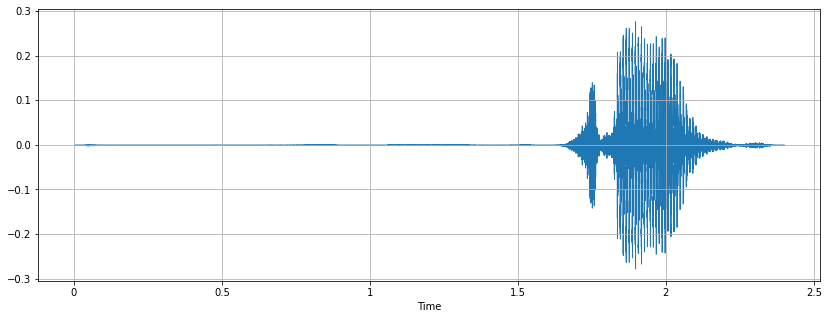

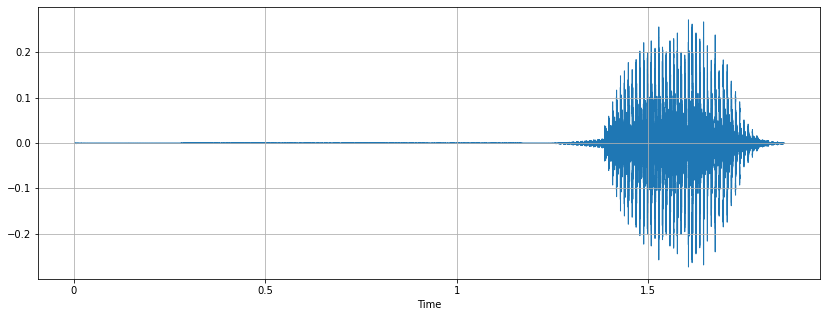

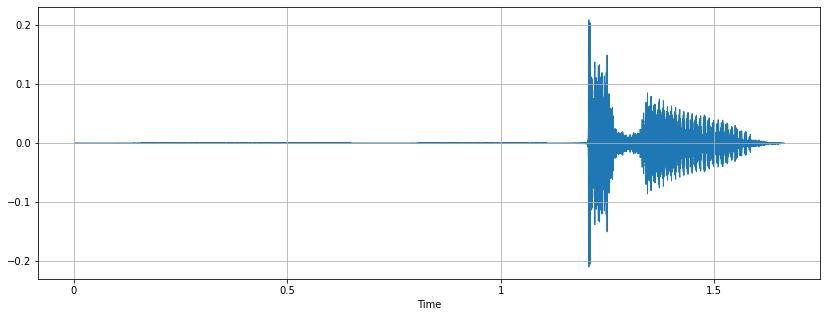

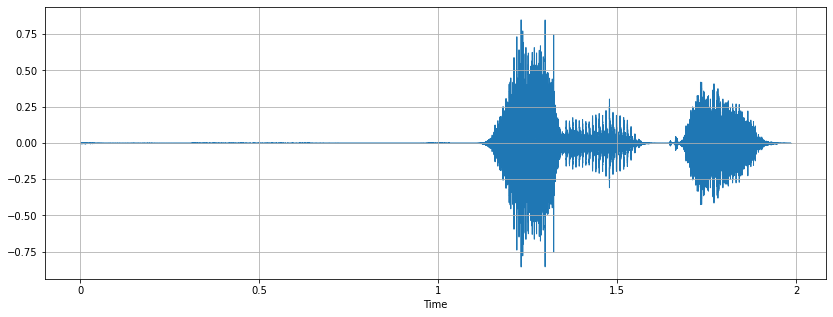

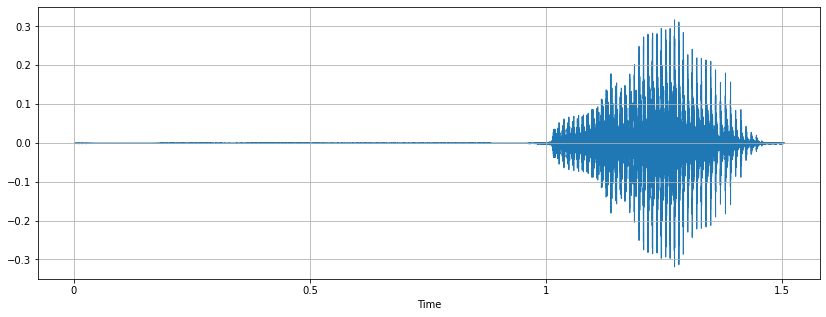

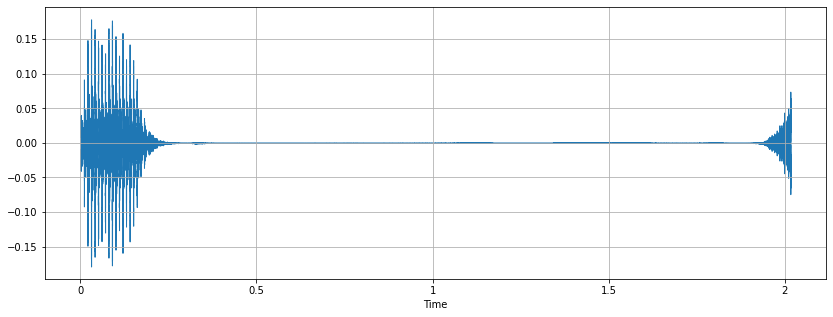

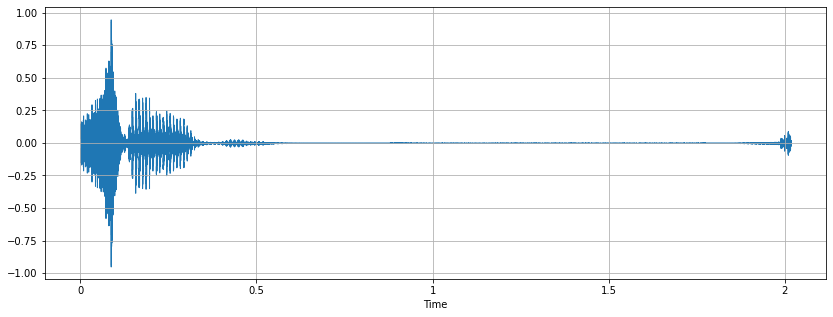

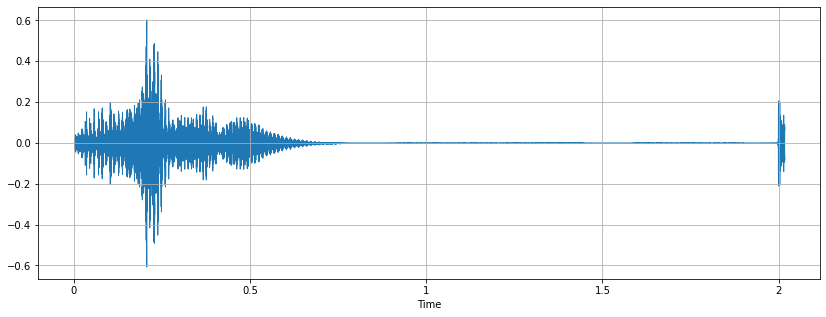

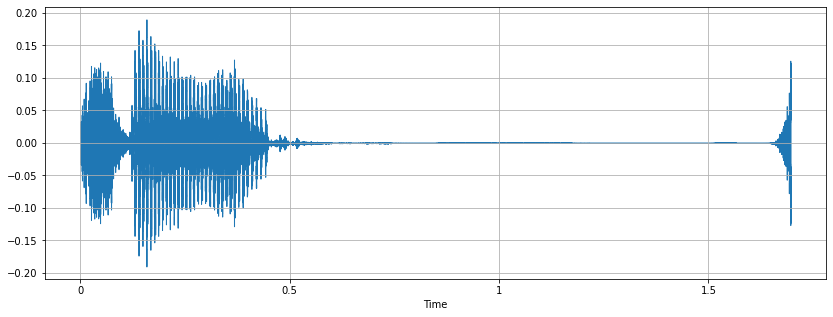

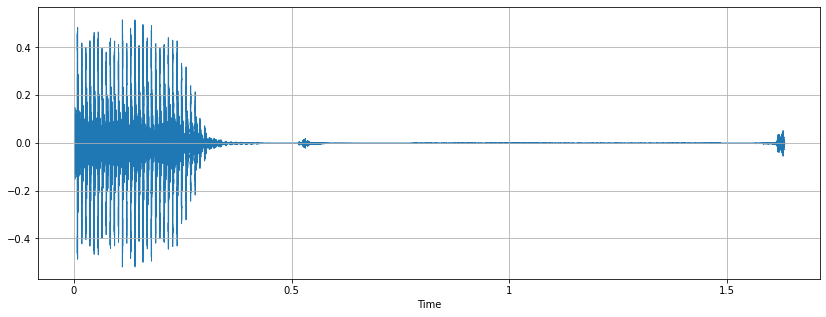

Digits found: 10


In [ ]:
# Segmentation and signal digit array calculation
_samples = digitSegmentation(filtered_signal)  # Segmenting audio file
digits_found = digitsFounder(filtered_signal, _samples)  # Finding digits signals from segmentation

In [ ]:
digits_found = np.array(digits_found)

In [ ]:
print(digits_found.shape)

(10, 128, 32)


In [ ]:
for digit in digits_found:
  digit = np.array([digit])
  print(predict(digit))

nine
three
three
zero
three
eight
two
six
five
two


In [ ]:
from random import seed, randint

In [ ]:
labels = ['three', 'five', 'seven', 'nine', 'zero', 'two', 'four', 'six', 'eight', 'one']
digits, mel_digits = [], []
audio_path = "/content/drive/MyDrive/Speech-Rec-Data/audio/{}"
for label in labels:
    label_path = audio_path.format(label)
    label_path = pathlib.Path(label_path)

    label_list = listdir(label_path)
    label_list_length = len(label_list)

    while True:
        seed(time())
        index = randint(0, label_list_length)
        digit_wav = label_list[index]
        digit_wav_path = pathlib.Path(join(str(label_path), digit_wav))
        digit, _ = load(digit_wav_path, sr=SAMPLE_RATE)

        if len(digit) == SAMPLE_RATE:
            mel_signal = showMelSpectrogram(digit)

            digits.append(digit)
            mel_digits.append(mel_signal)
            break

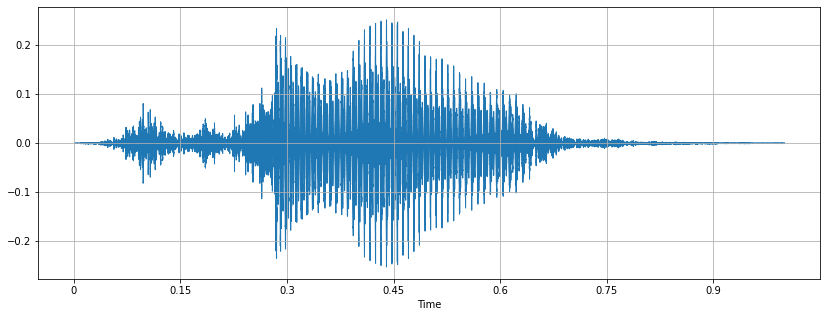

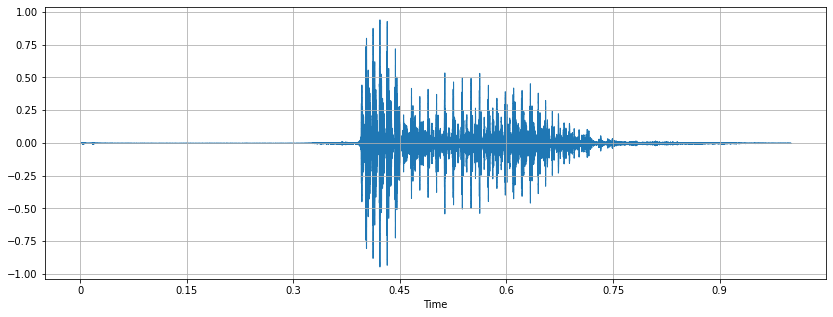

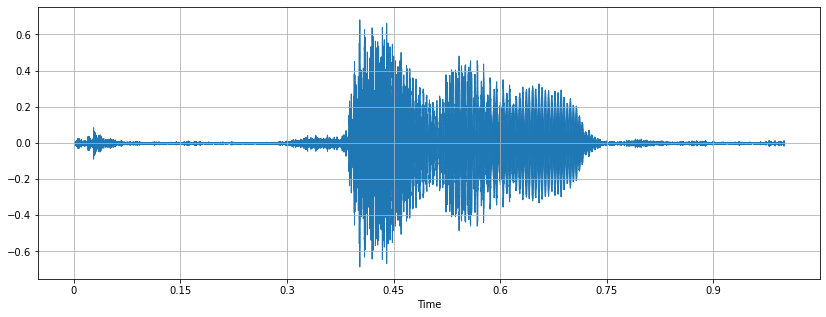

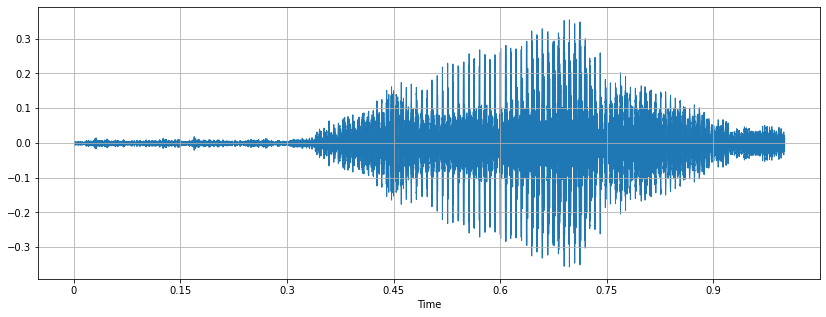

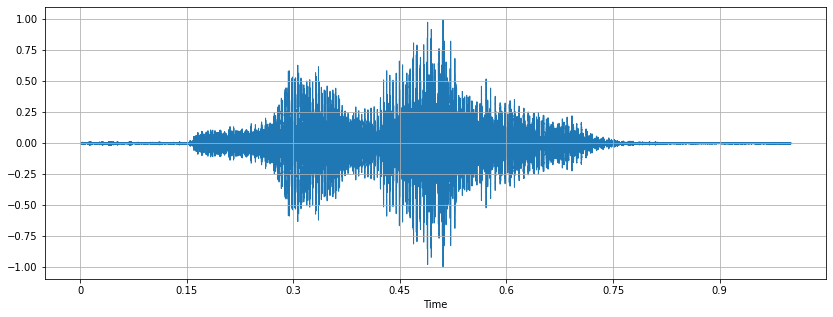

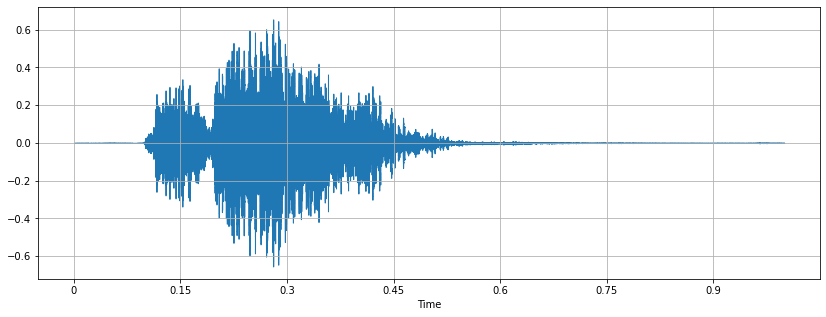

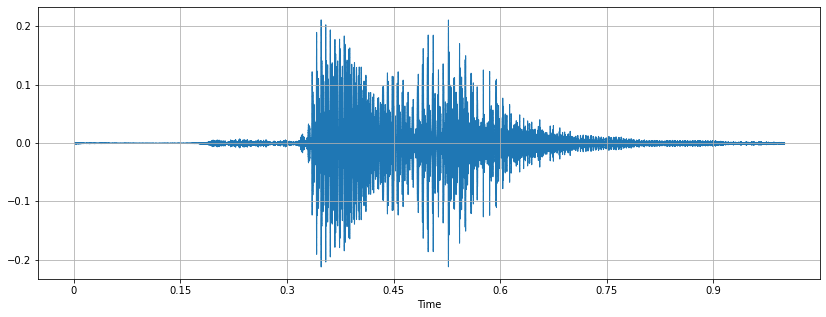

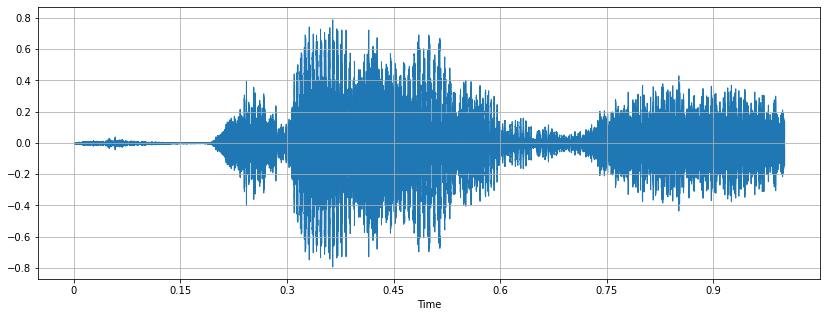

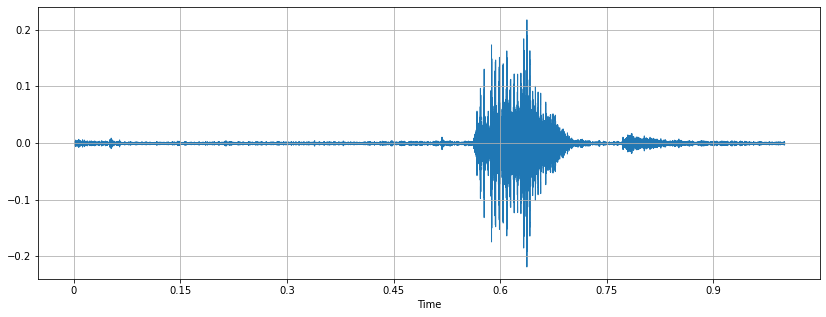

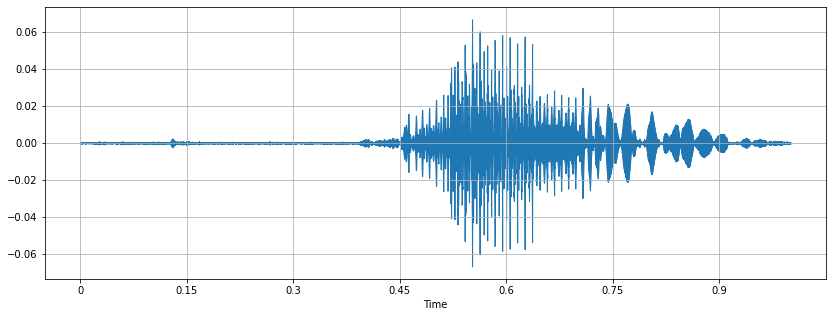

In [ ]:
for digit in digits:
    showSignal(digit)

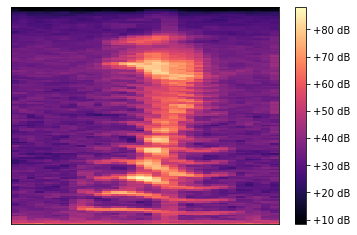

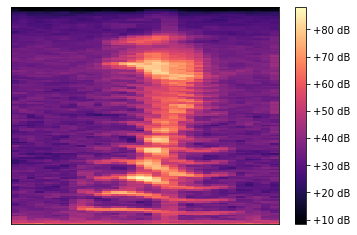

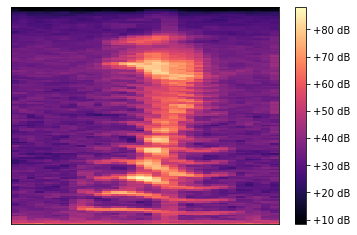

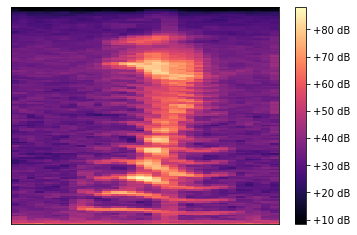

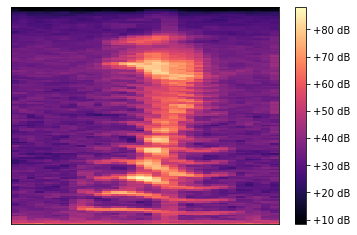

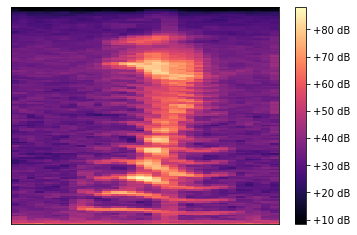

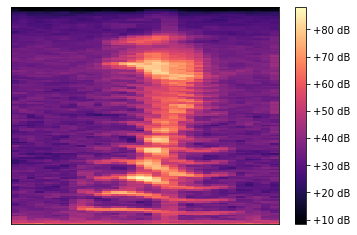

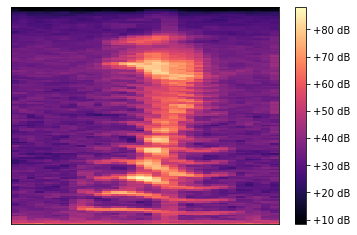

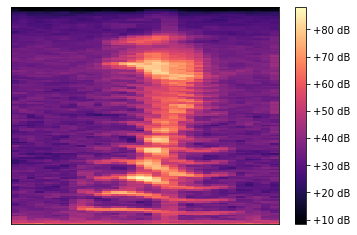

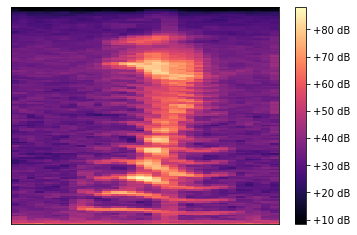

In [ ]:
for mel_digit in mel_digits:
    specshow(mel_spectrogram)
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [ ]:
for mel_digit in mel_digits:
    mel_digit = np.array([mel_digit])
    print(predict(mel_digit))

NameError: ignored